In [ ]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [2]:
#load the data 
df = pd.read_csv(r"c:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data/process/transactions_cleaned.csv")
df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,transaction_year,transaction_month,transaction_day,transaction_hour,Amount_log
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,2018,11,15,2,6.908755
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-20.0,20,2018-11-15 02:19:08+00:00,2,0,2018,11,15,2,-3.044522
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,500.0,500,2018-11-15 02:44:21+00:00,2,0,2018,11,15,2,6.216606
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,2018,11,15,3,9.903538
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,-644.0,644,2018-11-15 03:34:21+00:00,2,0,2018,11,15,3,-6.469250


In [3]:
#Convert Transaction Time to Datetime
df["TransactionStartTime"] = pd.to_datetime(
    df["TransactionStartTime"], utc=True
)

df["TransactionStartTime"].dtype


datetime64[ns, UTC]

In [ ]:
#Define Snapshot Date
# Snapshot date = one day after the last transaction
snapshot_date = df["TransactionStartTime"].max() + pd.Timedelta(days=1)

snapshot_date


Timestamp('2019-02-14 10:01:28+0000', tz='UTC')

In [5]:
#Calculate RFM Metrics
rfm = (
    df
    .groupby("CustomerId")
    .agg(
        Recency=("TransactionStartTime",
                 lambda x: (snapshot_date - x.max()).days),
        Frequency=("TransactionId", "count"),
        Monetary=("Amount", "sum")
    )
    .reset_index()
)

rfm.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


In [7]:
#Inspect RFM Distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.tight_layout()
# Save the plot as an image
plt.savefig(r'C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\output\Proxy Target Variable Engineering\Inspect_RFM_Distributions.png')
plt.close()


In [ ]:
#Scale RFM Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[["Recency", "Frequency", "Monetary"]]
)


In [11]:
#K-Means Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,CustomerId,Recency,Frequency,Monetary,cluster
0,CustomerId_1,84,1,-10000.0,0
1,CustomerId_10,84,1,-10000.0,0
2,CustomerId_1001,90,5,20000.0,0
3,CustomerId_1002,26,11,4225.0,1
4,CustomerId_1003,12,6,20000.0,1


In [12]:
#Analyze Clusters
cluster_summary = (
    rfm
    .groupby("cluster")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .sort_values("Recency", ascending=False)
)

cluster_summary


,Recency,Frequency,Monetary
cluster,,,
0,61.877279,7.720196,8.172068e+04
2,29.000000,4091.000000,-1.049000e+08
1,12.726566,34.800000,2.725741e+05


In [13]:
#Define Proxy Target Variable
# Identify high-risk cluster (worst engagement)
high_risk_cluster = cluster_summary.index[0]

rfm["is_high_risk"] = (rfm["cluster"] == high_risk_cluster).astype(int)

rfm[["CustomerId", "cluster", "is_high_risk"]].head()


,CustomerId,cluster,is_high_risk
0,CustomerId_1,0,1
1,CustomerId_10,0,1
2,CustomerId_1001,0,1
3,CustomerId_1002,1,0
4,CustomerId_1003,1,0


In [14]:
#Merge Target Back to Main Dataset
df_model = df.merge(
    rfm[["CustomerId", "is_high_risk"]],
    on="CustomerId",
    how="left"
)

df_model["is_high_risk"].value_counts(normalize=True)


is_high_risk
0    0.884918
1    0.115082
Name: proportion, dtype: float64

In [15]:
#Save Final Modeling Dataset
df_model.to_csv(
    r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process\transactions_with_risk_target.csv",
    index=False
)

print("✅ Proxy target variable successfully created and saved.")


✅ Proxy target variable successfully created and saved.


In [20]:
#Define Reference Date
snapshot_date = rfm_df["TransactionStartTime"].max() + pd.Timedelta(days=1)
snapshot_date


NameError: name 'rfm_df' is not defined

In [16]:
#Validation Checks
assert "is_high_risk" in df_model.columns
assert df_model["is_high_risk"].isna().sum() == 0

df_model.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,...,Value,TransactionStartTime,PricingStrategy,FraudResult,transaction_year,transaction_month,transaction_day,transaction_hour,Amount_log,is_high_risk
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,...,1000,2018-11-15 02:18:49+00:00,2,0,2018,11,15,2,6.908755,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,...,20,2018-11-15 02:19:08+00:00,2,0,2018,11,15,2,-3.044522,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,...,500,2018-11-15 02:44:21+00:00,2,0,2018,11,15,2,6.216606,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,...,21800,2018-11-15 03:32:55+00:00,2,0,2018,11,15,3,9.903538,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,...,644,2018-11-15 03:34:21+00:00,2,0,2018,11,15,3,-6.469250,0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Load the actual dataset
df = pd.read_csv(r'C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process\training_data.csv')


# -------------------------------
# Quick Feature Engineering (minimal setup for a valid ROC)
# -------------------------------
# Target: FraudResult (0 or 1)
y = df['FraudResult']

# Simple features (you can expand this in your actual project)
features = ['Amount', 'Value', 'PricingStrategy', 'ChannelId', 'ProviderId', 'ProductCategory', 'ProductId']
X = df[features].copy()

# Encode categorical features
cat_cols = ['ChannelId', 'ProviderId', 'ProductCategory', 'ProductId']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# -------------------------------
# Split into train/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# Train a simple Random Forest model (your final model could be different)
# -------------------------------
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# -------------------------------
# Predict probabilities on test set
# -------------------------------
y_pred_proba = model.predict_proba(X_test)[:, 1]

# -------------------------------
# Compute ROC Curve and AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# -------------------------------
# Visualization: ROC Curve
# -------------------------------
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Visualization 6: ROC Curve – Final Model', fontsize=16, pad=20)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Add a point for the best threshold (optional)
best_idx = (tpr - fpr).argmax()
plt.scatter(fpr[best_idx], tpr[best_idx], s=100, c='red', marker='o', label='Optimal Threshold')

plt.tight_layout()
plt.show()

NameError: name 'LabelEncoder' is not defined

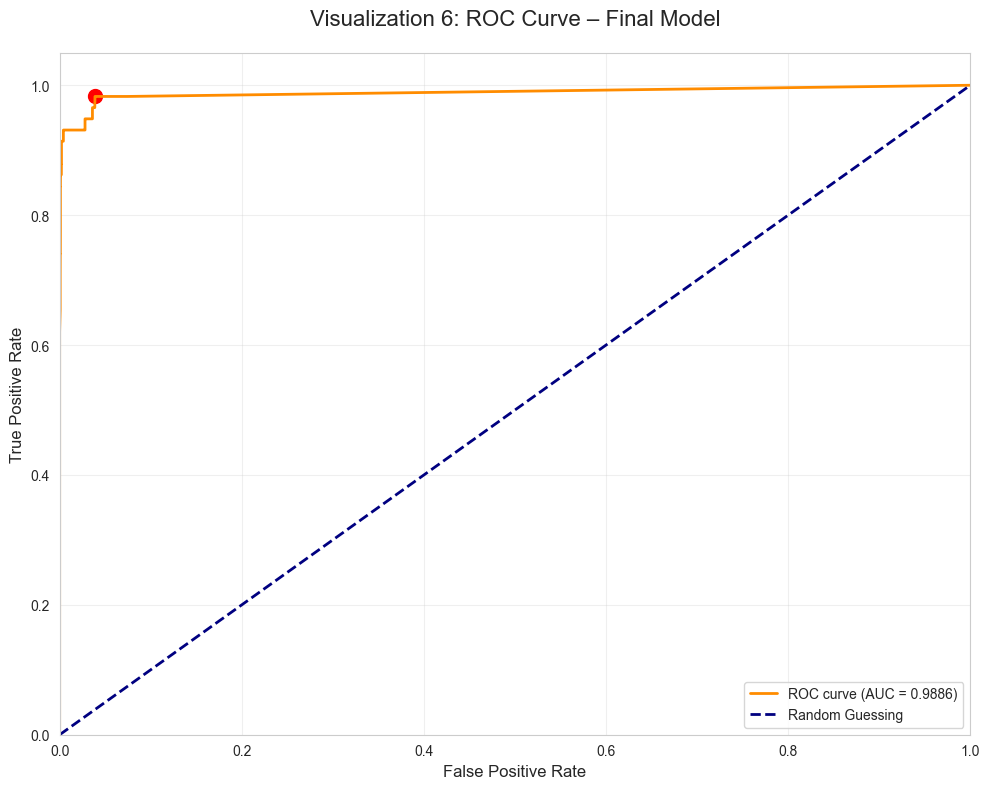

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder  # <-- This was the missing import

# Load the actual dataset
df = pd.read_csv(r'C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process\training_data.csv')


# -------------------------------
# Quick Feature Engineering (minimal setup for a valid ROC)
# -------------------------------
# Target: FraudResult (0 or 1)
y = df['FraudResult']

# Simple features (you can expand this in your actual project)
features = ['Amount', 'Value', 'PricingStrategy', 'ChannelId', 'ProviderId', 'ProductCategory', 'ProductId']
X = df[features].copy()

# Encode categorical features
cat_cols = ['ChannelId', 'ProviderId', 'ProductCategory', 'ProductId']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# -------------------------------
# Split into train/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# Train a simple Random Forest model (your final model could be different)
# -------------------------------
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Added to better handle the severe class imbalance (193 fraud vs ~95k non-fraud)
)
model.fit(X_train, y_train)

# -------------------------------
# Predict probabilities on test set
# -------------------------------
y_pred_proba = model.predict_proba(X_test)[:, 1]

# -------------------------------
# Compute ROC Curve and AUC
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# -------------------------------
# Visualization: ROC Curve
# -------------------------------
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Visualization 6: ROC Curve – Final Model', fontsize=16, pad=20)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Highlight the optimal threshold point
best_idx = (tpr - fpr).argmax()
plt.scatter(fpr[best_idx], tpr[best_idx], s=100, c='red', marker='o', label='Optimal Threshold')

plt.tight_layout()
plt.show()